width: 224, height: 224
left_image size: (224, 224)
right_image size: (224, 224)


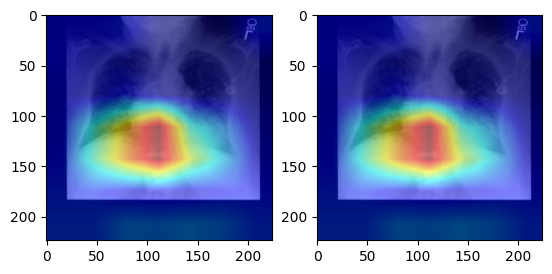

In [11]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import sys
sys.path.append('/media/NAS06/gavinyue/disentanglement')
# from fns_custom.fibmask import * 
# Load the image
image_path = '/media/NAS06/gavinyue/disentanglement/yingying_tasks/new/89_0010_heart size.png'
image = Image.open(image_path)#.convert('L')

# Get the dimensions of the original image
width, height = image.size
print(f'width: {width}, height: {height}')

# # Define the coordinates for cropping the two images
# left_image_coords = (0, 0, width // 2, height)
# right_image_coords = (width // 2, 0, width, height)



# # Left image (X-ray)
# # left_image_coords = (width * 0.05, 0, width * 0.45, height * 0.95)
# left_image = image.crop(left_image_coords)

# # # Right image (X-ray)
# # right_image_coords = (width * 0.55, height * 0.05, width * 0.95, height * 0.95)
# right_image = image.crop(right_image_coords)
left_image, right_image = image, image
print(f'left_image size: {left_image.size}')
print(f'right_image size: {right_image.size}')

# Save the cropped images
# left_image.save('/mnt/data/left_xray_image.jpg')
# right_image.save('/mnt/data/right_xray_image.jpg')

# Show the cropped images (optional)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(left_image,cmap='gray')
ax[1].imshow(right_image, cmap='gray')

18
limg_cropped shape: (183, 191, 3)
img 0 shape: (224, 224, 3)
img 1 shape: (224, 224, 3)
img 2 shape: (183, 191, 3)
img 3 shape: (224, 177, 3)


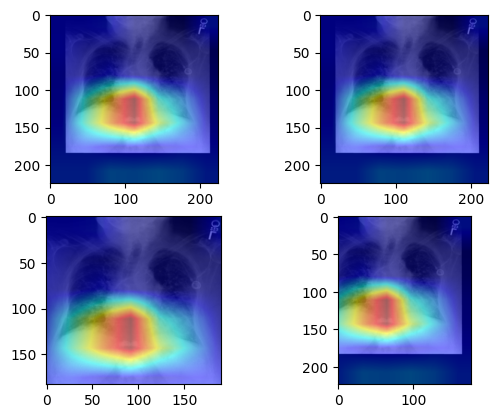

In [24]:
limg = np.array(left_image)
rimg = np.array(right_image)
# limg[0:114] = 0
# limg[785:] = 0
# limg[:,:17] = 0
# limg[:, 690:] = 0


# rimg[0:114] = 0
# rimg[785:] = 0
# rimg[:,:66] = 0
# rimg[:, 739:] = 0

# Crop the images to the non-zero area
limg_cropped = limg[:int(420*0.4375), int(47*0.4375):int(484*0.4375)]
rimg_cropped = rimg[:420, 47:484]
print(f'limg_cropped shape: {limg_cropped.shape}')


imgs = [limg, rimg, limg_cropped, rimg_cropped]
fig, axes = plt.subplots(2, 2)
ax = axes.ravel()
for i in range(len(ax)):
    ax[i].imshow(imgs[i], cmap='gray')
    print(f'img {i} shape: {imgs[i].shape}')
    # ax[i].axis('off')

# 47, 484

for col in range(100):
    row =200
    if rimg[row,col,0] != 0:
        print(row,col)
        print(rimg[row,col])
        break
for col in range(rimg.shape[1] - 1, 400, -1):
    row = 200
    if rimg[row, col,0] != 0:
        print(row, col)
        print(rimg[row, col])
        found = True
        break

# for row in range(100):
#     col =200
#     if rimg[row,col,0] != 0:
#         print(row,col)
#         print(rimg[row,col])
#         break
# for row in range(500, 400, -1):
#     col = 200
#     if rimg[row, col,0] != 0:
#         print(row, col)
#         print(rimg[row, col])
#         found = True
#         break

# img1 = limg_cropped; img2 = rimg_cropped
limg_cropped = Image.fromarray(limg_cropped)
limg_cropped.save("/media/NAS06/gavinyue/disentanglement/yingying_tasks/new/89_0010_heart_resized.png")

Mask Area: 33581, Min Area: 1679.0500000000002
Component 10 has area 2964
Component 17 has area 7063
Component 21 has area 5717
Component 22 has area 2914
Intersection Area: 7063, Mask Area: 7063
Intersection Area: 5717, Mask Area: 5717
Intersection Area: 2964, Mask Area: 2964
Intersection Area: 0, Mask Area: 2914


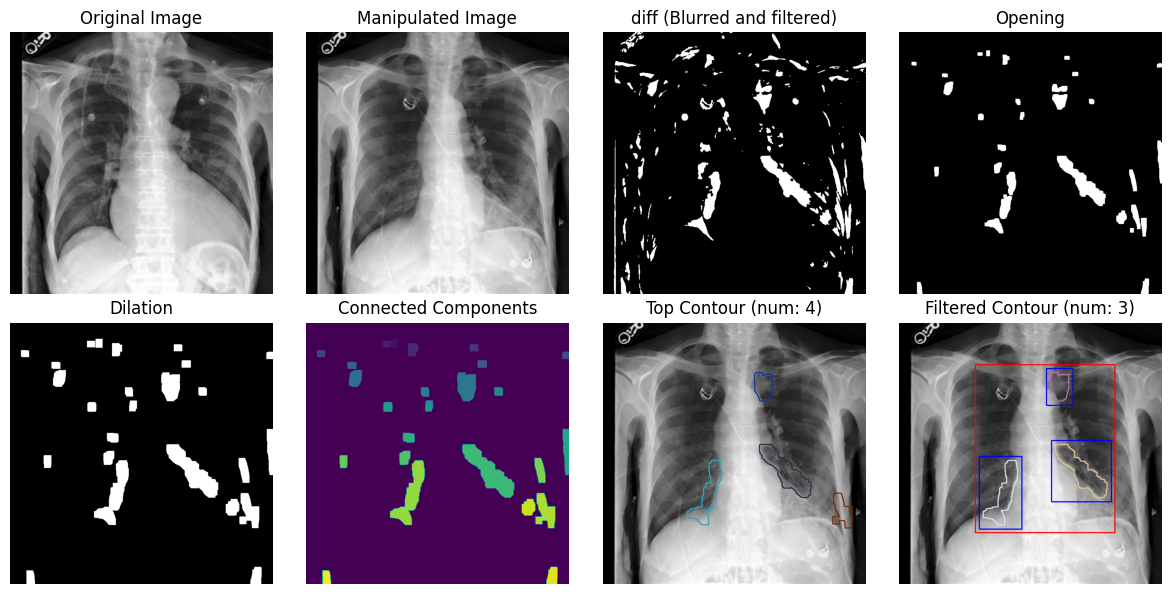

In [18]:
def get_intersection_mask(img1, img2):
    # Convert images to grayscale and apply Gaussian blur
    gray_img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY) if img1.ndim == 3 else img1
    gray_img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY) if img2.ndim == 3 else img2
    gray_img1 = cv2.GaussianBlur(gray_img1, (7, 7), 0)
    gray_img2 = cv2.GaussianBlur(gray_img2, (7, 7), 0)

    # Apply thresholding to get binary images
    # _, thresh_img1 = cv2.threshold(gray_img1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, thresh_img2 = cv2.threshold(gray_img2, 30, 255, cv2.THRESH_BINARY)
    # Create masks from contours
    mask_img1 = np.zeros_like(gray_img1)
    mask_img2 = np.zeros_like(gray_img2)

    # Find contours for the whole image
    contours_img1, _ = cv2.findContours(gray_img1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_img2, _ = cv2.findContours(thresh_img2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    cv2.drawContours(mask_img1, contours_img1, -1, color=255, thickness=cv2.FILLED)
    cv2.drawContours(mask_img2, contours_img2, -1, color=255, thickness=cv2.FILLED)

    combined_mask = cv2.bitwise_and(mask_img1, mask_img2)
    return combined_mask

def get_diff_masks(img1, img2):
    assert len(img1.shape) == 2 and len(img2.shape) == 2, "Input images must be grayscale" 
                
    # Compute the absolute difference between the blurred images
    diff = cv2.absdiff(img1, img2)

    # # Remove shape artefactes (hollow and decreased edges)
    combined_mask = get_intersection_mask(img1, img2)
    diff = cv2.bitwise_and(diff, diff, mask=combined_mask)

    # # normalise to [0,255] Useless!
    diff = cv2.normalize(diff, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    # Apply Gaussian Blur to reduce noise
    diff = cv2.GaussianBlur(diff, (5, 5), 0)
    # Apply Otsu's thresholding to get a binary mask
    _, diff_mask = cv2.threshold(diff, 50, 255, cv2.THRESH_BINARY)
    return diff_mask

def get_boxes(img):
    contours = max(cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0], key=cv2.contourArea, default=None)
    if contours is None:
        print(f"Failed to find a box for input image")
        return None

    def draw_box(contour):
        x, y, w, h = cv2.boundingRect(contour)
        mx_start, mx_end = x  + int(w * 0.15), x  + int(w * 0.85)
        my_start, my_end = y + int(h * 0.15), y + int(h * 0.85)
        return (mx_start, my_start, mx_end - mx_start, my_end - my_start)

    middle_box = draw_box(contours)
    return np.array(middle_box)

def get_prompt_box(contour, offset=0):
    x, y, w, h = cv2.boundingRect(contour)
    mx_start, mx_end = x - int(offset/2), x  + int(w) + int(offset/2)
    my_start, my_end = y - int(offset/2), y + int(h) + int(offset/2)
    return np.array([mx_start, my_start, mx_end - mx_start, my_end - my_start])
    


import random
def get_fib_mask(orig_img, manip_img, show=False, middle_boxes=None, debug=False):
    diff_mask = get_diff_masks(orig_img, manip_img)
    # Step 2: Morphological Opening and Dilation
    kernel = np.ones((5, 5), np.uint8)
    opening = cv2.morphologyEx(diff_mask, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_fg = cv2.dilate(opening, kernel, iterations=2)

    # Step 3: Connected Component Analysis
    num_labels, labels_im = cv2.connectedComponents(sure_fg)

    # Step 4: Filter Components
    # 4.1 Minimum Component is 3% of the mask area
    # 4.2 Sort components by area in descending order and select the top 8
    mask_area = cv2.countNonZero(sure_fg)
    min_area = mask_area * 0.05
    print(f"Mask Area: {mask_area}, Min Area: {min_area}")

    selected_mask = np.zeros_like(sure_fg)
    components = []
    for label in range(1, num_labels):
        component_mask = (labels_im == label).astype(np.uint8) * 255
        area = cv2.countNonZero(component_mask)
        if area >= min_area:
            components.append((area, component_mask))
            print(f"Component {label} has area {area}")
    
    components.sort(key=lambda x: x[0], reverse=True)
    top_components = components[:5]
    output_image = cv2.cvtColor(manip_img.copy(), cv2.COLOR_GRAY2BGR)


    mbox = get_boxes(manip_img)
    # cv2.rectangle(output_image, (mbox[0], mbox[1]), (mbox[0] + mbox[2], mbox[1] + mbox[3]), (0, 0, 255), 2)
    box_mask = np.zeros_like(manip_img, dtype=np.uint8)
    cv2.rectangle(box_mask, (mbox[0], mbox[1]), (mbox[0] + mbox[2], mbox[1] + mbox[3]), 255, thickness=cv2.FILLED)   
    
    
    
    output_image1 = cv2.cvtColor(manip_img.copy(), cv2.COLOR_GRAY2BGR)
    for area, mask in top_components: 
    # Calculate the intersection of the selected mask with the box
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 
        random_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))# Draw contours with the random color
        cv2.drawContours(output_image1, contours, -1, random_color, 2) 
    
    for area, mask in top_components: 
        # Calculate the intersection of the selected mask with the box
        intersection = cv2.bitwise_and(mask, box_mask)
        intersection_area = cv2.countNonZero(intersection)
        print(f"Intersection Area: {intersection_area}, Mask Area: {cv2.countNonZero(mask)}")
        mask_area = cv2.countNonZero(mask)
        if intersection_area > 0.8 * mask_area:
            selected_mask = cv2.bitwise_or(selected_mask, mask)
    
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 
            random_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))# Draw contours with the random color
            for contour in contours:
                box = get_prompt_box(contour,offset=20)
                cv2.rectangle(output_image, (box[0], box[1]), (box[0] + box[2], box[1] + box[3]), (0, 0, 255), 2)
            cv2.drawContours(output_image, contours, -1, random_color, 2)    
        
    # Step 6: Contour Detection on Selected Components
    filter_contours, _ = cv2.findContours(selected_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    segmentation_mask = np.zeros_like(selected_mask, dtype=np.uint8)
    cv2.drawContours(segmentation_mask, filter_contours, -1, 255, thickness=cv2.FILLED)

    # Step 7: fill holes
    segmentation_mask = cv2.morphologyEx(segmentation_mask, cv2.MORPH_CLOSE, kernel, iterations=3)
    
    gt2D = segmentation_mask
    y_indices, x_indices = np.where(gt2D > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = gt2D.shape
    x_min = max(0, x_min - 20)
    x_max = min(W, x_max + 20)
    y_min = max(0, y_min - 20)
    y_max = min(H, y_max + 20)
    bbox = np.array([x_min, y_min, x_max, y_max])
    cv2.rectangle(output_image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 0), 2)
    
                
            
    if show:
        fig, axes = plt.subplots(2, 4, figsize=(12, 6)) 
        images = [orig_img, manip_img, diff_mask, opening]
        titles = ["Original Image", "Manipulated Image", 'diff (Blurred and filtered)','Opening']
        for i, (img, title) in enumerate(zip(images, titles)):
            axes[0, i].imshow(img, cmap='gray')
            axes[0, i].set_title(title)
        
        images2 = [sure_fg, labels_im, output_image1, output_image]
        # titles2 = ['Dilation', 'Connected Components', f'Filtered Contour (num: {len(filter_contours)})', f'Segmentation Mask (num: {len(filter_contours)})']
        titles2 = ['Dilation', 'Connected Components', f'Top Contour (num: {len(top_components)})', f'Filtered Contour (num: {len(filter_contours)})']
        for i, (img, title) in enumerate(zip(images2, titles2)):
            axes[1, i].imshow(img, cmap='gray' if i != 1 else None)
            axes[1, i].set_title(title)

        for ax in axes.flatten():
            ax.axis('off')
        plt.tight_layout()
        plt.show()
    return output_image, segmentation_mask, len(top_components), len(filter_contours)


output_image, segmentation_mask, l1, l2 = get_fib_mask(img1, img2, show=True)


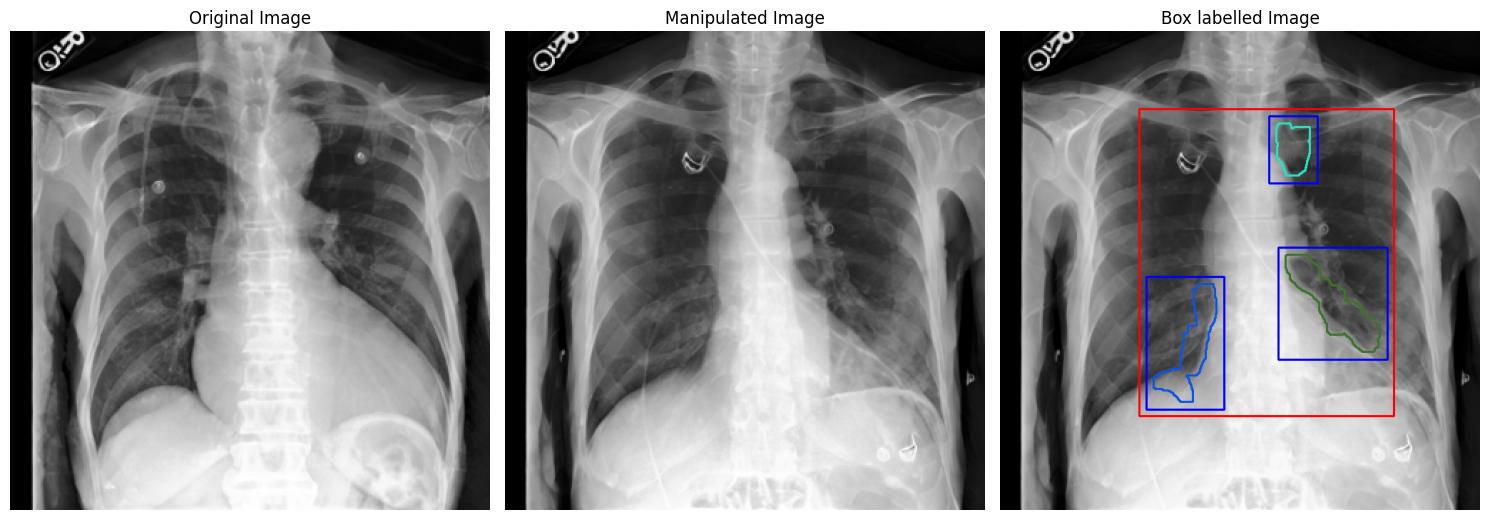

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
axes[0].imshow(img1, cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(img2, cmap='gray')
axes[1].set_title('Manipulated Image')
axes[2].imshow(output_image)
axes[2].set_title('Box labelled Image')
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.savefig('/media/NAS06/gavinyue/disentanglement/yingying_tasks/box_labelled.png')